In [ ]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
import pandas as pd

import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# # Random state.
RS = 20150101

# # We'll use matplotlib for graphics.
# import matplotlib.pyplot as plt
# import matplotlib.patheffects as PathEffects
# import matplotlib
%matplotlib inline

# # We import seaborn to make nice plots.
# import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_palette('muted')
# sns.set_context("notebook", font_scale=1.5,
#                 rc={"lines.linewidth": 2.5})

# # We'll generate an animation with matplotlib and moviepy.
# from moviepy.video.io.bindings import mplfig_to_npimage
# import moviepy.editor as mpy

In [2]:
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'
df = pd.read_csv(dataroot+'deep_features_all.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,1.5985,0.64312,0,0,0,0,0,...,0,0,0.00000,0,0,7.5054,0.0000,0.00000,0,0.0000
1,0,0,0,0.0000,0.00000,0,0,0,0,0,...,0,0,0.87618,0,0,0.0000,0.0000,0.00000,0,0.0000
2,0,0,0,0.0000,1.90650,0,0,0,0,0,...,0,0,0.00000,0,0,0.0000,1.5067,0.00000,0,0.0000
3,0,0,0,0.0000,0.67637,0,0,0,0,0,...,0,0,0.00000,0,0,0.0000,0.0000,0.57079,0,1.0956
4,0,0,0,0.0000,0.00000,0,0,0,0,0,...,0,0,0.00000,0,0,0.0000,0.0000,0.00000,0,0.0000


In [3]:
df_label = pd.read_csv(dataroot+'test_stats_all.csv')
df_label.head()

,lat,lng,dir,label,label_num,ownScore,predLabel,predLabel_num,bestScore
0,42.300087,-71.073887,0,boston_Dorchester,13,0.000505,chicago_McKinleyPark,50,0.748218
1,42.300148,-71.100771,0,boston_Roxbury,29,0.030952,newyork_UpperWestSide,83,0.355452
2,42.300385,-71.082837,0,boston_Dorchester,13,0.919349,boston_Dorchester,13,0.919349
3,42.300864,-71.072219,3,boston_Dorchester,13,0.945544,boston_Dorchester,13,0.945544
4,42.300945,-71.110584,1,boston_JamaicaPlain,19,0.069976,boston_Roxbury,29,0.133831


In [ ]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('images/digits-generated.png', dpi=150)

In [ ]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [ ]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
scatter(digits_proj, y)
plt.savefig('images/digits_tsne-generated.png', dpi=120)

Computing PCA projection
Computing t-SNE embedding


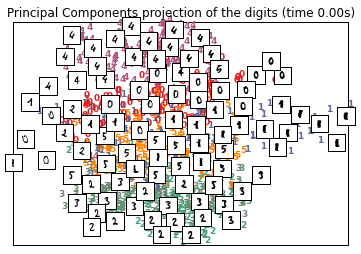

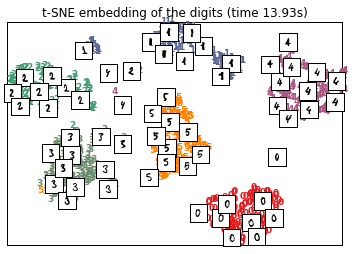

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition)

%matplotlib inline

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()